In [5]:
# some_file.py
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '/home/zcapjru/PhD/DEScls/xcell/mappers')

from mapper_base import MapperBase
from astropy.io import fits
from astropy.table import Table
from scipy.interpolate import interp1d

import mapper_P15CMBK
import pandas as pd
import numpy as np
import healpy as hp
import pymaster as nmt
import pylab as plt
import pyccl as ccl
import os

In [6]:
CMBK_config = {'file_klm':'/home/zcapjru/PhD/Data/COM_Lensing_2048_R2.00/dat_klm.fits', 
          'file_mask':'/home/zcapjru/PhD/Data/COM_Lensing_2048_R2.00/mask.fits.gz',
               'file_noise':'/home/zcapjru/PhD/Data/COM_Lensing_2048_R2.00/nlkk.dat',
               'mask_name': 'mask_CMBK',
          'nside':2048}

In [7]:
CMBK_maps = mapper_P15CMBK.MapperP15CMBK(CMBK_config)

/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(


/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/healpy/sphtfunc.py:822: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  warnings.warn(
/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 0.000000 arcmin
  warnings.warn(
/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a 

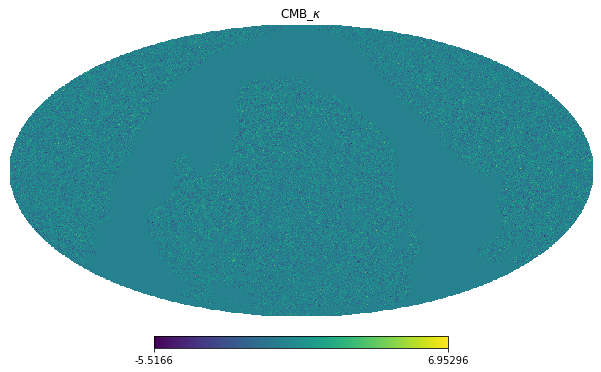

In [4]:
signal = CMBK_maps.get_signal_map()
hp.visufunc.mollview(signal[0], title= r'CMB_$\kappa$')

In [ ]:
mask = CMBK_maps.get_mask()
hp.visufunc.mollview(mask, title= r'CMB_$\kappa$')

In [ ]:
l = CMBK_maps.get_ells()

In [ ]:
ells = []
i = 11.5
while i <= l[-1]:
    ells.append(round(i))
    #i = i*(1+i/(3 * nside))
    i = i+20*(1+i/500)

bands = nmt.NmtBin.from_edges(ells[:-1], ells[1:])
ell_arr = bands.get_effective_ells()

In [ ]:
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.049, h=0.67, sigma8=0.81, n_s=0.96)
CMB_shear = ccl.CMBLensingTracer(cosmo, 1100)
shear_shear_theory = ccl.angular_cl(cosmo, CMB_shear, CMB_shear, ell_arr) 

In [ ]:
CMBK_f = CMBK_maps.get_nmt_field()

In [ ]:
nl_coupled = CMBK_maps.get_nl()

In [ ]:
cl_fid = CMBK_maps.get_cl_fiducial()

In [ ]:
CMBK_w = nmt.NmtWorkspace()
CMBK_w.compute_coupling_matrix(CMBK_f, CMBK_f, bands)

In [ ]:
def compute_cl(f_a, f_b, wsp):
    # Compute the power spectrum (a la anafast) of the masked fields
    # Note that we only use n_iter=0 here to speed up the computation,
    # but the default value of 3 is recommended in general.
    cl_coupled = nmt.compute_coupled_cell(f_a, f_b)
    # Decouple power spectrum into bandpowers inverting the coupling matrix
    cl_decoupled = wsp.decouple_cell(cl_coupled) #removed bias here

    return cl_decoupled

In [ ]:
CMBK_cl = compute_cl(CMBK_f, CMBK_f, CMBK_w)

In [ ]:
#CMBK_nl = CMBK_w.decouple_cell(nl_coupled)
#Dimensionality =/= np.ones(3*self.nside) doesn't work 

In [ ]:
nl_inter = interp1d(l, nl_coupled[0], kind='cubic')

In [ ]:
plt.plot(l, nl_coupled[0], 'r-', label='noise ')
plt.plot(ell_arr, nl_inter(ell_arr) , 'b--', label='noise interpol')
plt.loglog()
plt.title('CMB lensing Cl')
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

In [ ]:
plt.plot(ell_arr, CMBK_cl[0] -nl_inter(ell_arr), 'r-', label='Data')
plt.plot(ell_arr, shear_shear_theory , 'r--', label='Theory')
plt.loglog()
plt.title('CMB lensing Cl')
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

In [ ]:
 CMBK_cl[0]